In [43]:
Nn = 3
Ns = 6
N = 2
PBC = 0 #nie dziala
Λ = 1000
ΛDMRG = 100000
ω = 0
maxOcc = N
g = '0.00' #or 'infty'

In [44]:
import time

print("Importing libraries...",end='')
t0 = time.time()

import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import ishermitian
from numpy import sqrt,exp,pi,zeros,arange,copy, sin, pi,loadtxt,poly1d, ones,reshape,floor

from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy

D = 1/Ns

print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))

Importing libraries...DONE in 0.272 [ms]


In [45]:
print("Loading corrs list...",end='')
t0 = time.time()

Corrs1_DMRG = {}
data = loadtxt('./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_%s'%(N,Ns,Nn,PBC,ΛDMRG,ω,g,'DMRG'))

for row in data:
    Corrs1_DMRG[tuple([int(x) for x in row[0:-1]])] = float(row[-1])

Corrs2_DMRG = {}
data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_%s'%(N,Ns,Nn,PBC,ΛDMRG,ω,g,'DMRG'))

for row in data:
    Corrs2_DMRG[tuple([int(x) for x in row[0:-1]])] = float(row[-1])
                                                                           
                                                                           
Corrs1_ED = {}
data = loadtxt('./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_%s'%(N,Ns,Nn,PBC,Λ,ω,g,'ED'))

for row in data:
    Corrs1_ED[tuple([int(x) for x in row[0:-1]])] = float(row[-1])
    
Corrs2_ED = {}
data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_%s'%(N,Ns,Nn,PBC,Λ,ω,g,'ED'))

for row in data:
    Corrs2_ED[tuple([int(x) for x in row[0:-1]])] = float(row[-1])

print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))

Loading corrs list...DONE in 11.387 [ms]


In [46]:
def fg(j,n,x):
    if n==0:
        return 1/sqrt(D)
    if n==1:
        return sqrt(3/D)*(2*x/D-2*j-1)
    if n==2:
        return sqrt(5/4/D)*(3*(2*x/D-2*j-1)**2-1)
    print("ErrG")
    return 0

def rhoRef(x,t='hermit'):
    if t =='hermit':
        return N*sqrt(ω/pi)*exp(-ω*x**2)
    if t =='qwell':
        return N*2*sin(pi*(x+1/2))**2

def rho(x):
    j = floor(x/D)
   
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            out += fg(j,n,x)*fg(j,np,x)*Corrs1[j,n,j,np]
    return out

def G1(x,xp):
    j = floor(x/D)
    jp = floor(xp/D)
    
    out_DMRG = 0
    out_ED = 0
    for n in range(Nn):
        for np in range(Nn):
            out_DMRG += fg(j,n,x)*fg(jp,np,xp)*Corrs1_DMRG[j,n,jp,np]
            out_ED += fg(j,n,x)*fg(jp,np,xp)*Corrs1_ED[j,n,jp,np]
    return out_ED,out_DMRG

def G2(x,xp):
    j = floor(x/D)
    jp = floor(xp/D)
    
    out_DMRG = 0
    out_ED = 0
    for n in range(Nn):
        for np in range(Nn):
            for npp in range(Nn):
                for nppp in range(Nn):
                    out_DMRG += fg(j,n,x)*fg(jp,np,xp)*fg(jp,npp,xp)*fg(j,nppp,x)*Corrs2_DMRG[j,jp,n,np,npp,nppp]
                    out_ED += fg(j,n,x)*fg(jp,np,xp)*fg(jp,npp,xp)*fg(j,nppp,x)*Corrs2_ED[j,jp,n,np,npp,nppp]
    return out_ED,out_DMRG
    
    

print("Computing Correlations...",end='')
t0 = time.time()

xs = arange(-0.5,0.5,1/99)

G1s_DMRG = zeros((len(xs),len(xs)),dtype=float)
G2s_DMRG = zeros((len(xs),len(xs)),dtype=float)

G1s_ED = zeros((len(xs),len(xs)),dtype=float)
G2s_ED = zeros((len(xs),len(xs)),dtype=float)


for ix in range(len(xs)):
    for ixp in range(len(xs)):
        G1s_ED[ix,ixp],G1s_DMRG[ix,ixp] = G1(xs[ix],xs[ixp])
        G2s_ED[ix,ixp],G2s_DMRG[ix,ixp] = G2(xs[ix],xs[ixp])
        

rhosQWell = []

for x in xs:
    rhosQWell.append( rhoRef(x,t='qwell') )
        
print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))  

Computing Correlations...DONE in 3729.554 [ms]


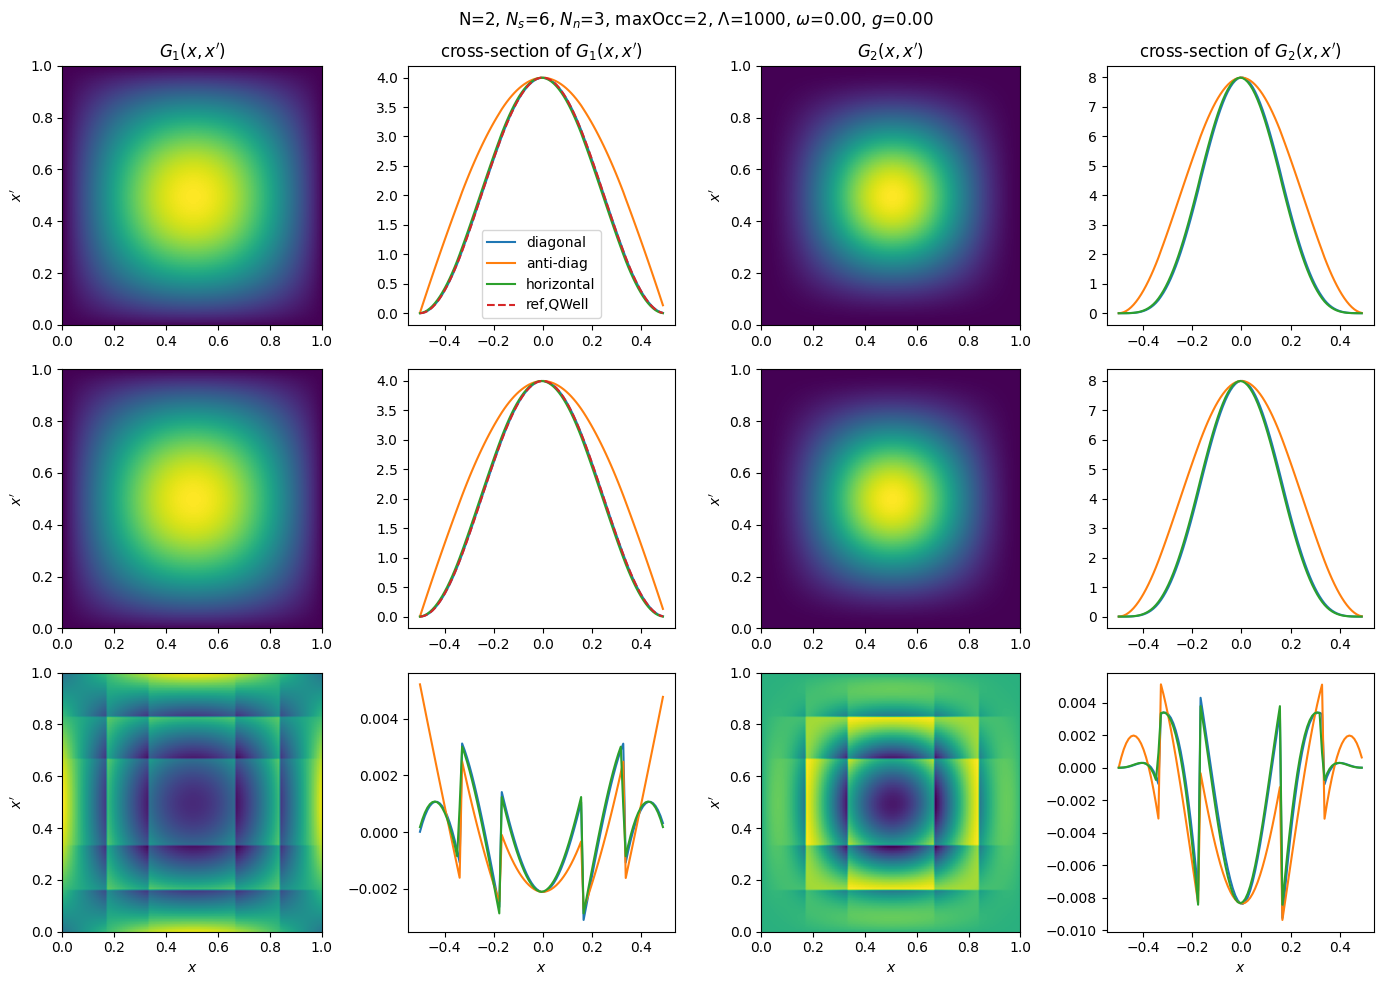

In [47]:
fig, ax = plt.subplots(3,4,figsize=[14,10])

fig.suptitle('N=%i, $N_s$=%i, $N_{n}$=%i, maxOcc=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%s'%(N,Ns,Nn,maxOcc,Λ,ω,g,))

cmap = ax[0,0].imshow(G1s_ED,extent =[0,1,0,1])
cmap = ax[0,2].imshow(G2s_ED,extent =[0,1,0,1])


ax[0,1].plot(xs,[G1s_ED[i,i] for i in range(len(xs))],label='diagonal')
ax[0,1].plot(xs,[G1s_ED[int(len(xs)/2),i] for i in range(len(xs))],label='anti-diag')
ax[0,1].plot(xs,[G1s_ED[i,len(xs)-i-1] for i in range(len(xs))],label='horizontal')

ax[0,1].plot(xs,rhosQWell,'--',label='ref,QWell')

ax[0,3].plot(xs,[G2s_ED[i,i] for i in range(len(xs))])
ax[0,3].plot(xs,[G2s_ED[int(len(xs)/2),i] for i in range(len(xs))])
ax[0,3].plot(xs,[G2s_ED[i,len(xs)-i-1] for i in range(len(xs))])


cmap = ax[1,0].imshow(G1s_DMRG,extent =[0,1,0,1])
cmap = ax[1,2].imshow(G2s_DMRG,extent =[0,1,0,1])


ax[1,1].plot(xs,[G1s_DMRG[i,i] for i in range(len(xs))],label='diagonal')
ax[1,1].plot(xs,[G1s_DMRG[int(len(xs)/2),i] for i in range(len(xs))],label='anti-diag')
ax[1,1].plot(xs,[G1s_DMRG[i,len(xs)-i-1] for i in range(len(xs))],label='horizontal')

ax[1,1].plot(xs,rhosQWell,'--',label='ref,QWell')

ax[1,3].plot(xs,[G2s_DMRG[i,i] for i in range(len(xs))])
ax[1,3].plot(xs,[G2s_DMRG[int(len(xs)/2),i] for i in range(len(xs))])
ax[1,3].plot(xs,[G2s_DMRG[i,len(xs)-i-1] for i in range(len(xs))])



cmap = ax[2,0].imshow(G1s_ED-G1s_DMRG,extent =[0,1,0,1])
cmap = ax[2,2].imshow(G2s_ED-G2s_DMRG,extent =[0,1,0,1])

ax[2,1].plot(xs,[G1s_ED[i,i]-G1s_DMRG[i,i] for i in range(len(xs))],label='diagonal')
ax[2,1].plot(xs,[G1s_ED[int(len(xs)/2),i]-G1s_DMRG[int(len(xs)/2),i] for i in range(len(xs))],label='anti-diag')
ax[2,1].plot(xs,[G1s_ED[i,len(xs)-i-1]-G1s_DMRG[i,len(xs)-i-1] for i in range(len(xs))],label='horizontal')

ax[2,3].plot(xs,[G2s_ED[i,i]-G2s_DMRG[i,i] for i in range(len(xs))])
ax[2,3].plot(xs,[G2s_ED[int(len(xs)/2),i]-G2s_DMRG[int(len(xs)/2),i] for i in range(len(xs))])
ax[2,3].plot(xs,[G2s_ED[i,len(xs)-i-1]-G2s_DMRG[i,len(xs)-i-1] for i in range(len(xs))])

ax[0,0].set_title("$G_1(x,x')$")
ax[0,1].set_title("cross-section of $G_1(x,x')$")
ax[0,2].set_title("$G_2(x,x')$")
ax[0,3].set_title("cross-section of $G_2(x,x')$")
# #ax[0].cbar(cmap)
ax[2,0].set_xlabel('$x$')
ax[0,0].set_ylabel("$x'$")
ax[1,0].set_ylabel("$x'$")
ax[2,0].set_ylabel("$x'$")
ax[2,1].set_xlabel('$x$')
ax[2,2].set_xlabel('$x$')
ax[0,2].set_ylabel("$x'$")
ax[1,2].set_ylabel("$x'$")
ax[2,2].set_ylabel("$x'$")
ax[2,3].set_xlabel('$x$')
ax[0,1].legend()
plt.tight_layout()
#plt.savefig('./figures/Correlations_N%i_Ns%i_Nn%i_maxOcc%i_PBC%i_Lambda%.2f_omega%.2f_g%s_%s.pdf'%(N,Ns,Nn,maxOcc,PBC,Λ,ω,g,source), dpi=300 )
plt.show()